## Benchmark model

### Train, test and validation split

IBM Stock train, test and validation split

In [59]:
train_size = int(len(df_ibm) * 0.90)
test_size = int(len(df_ibm) * 0.08)
valid_size = len(df_ibm) - (train_size + test_size)
df_ibm_train, df_ibm_test, df_ibm_valid = df_ibm[0:train_size].copy(),\
                                            df_ibm[train_size:train_size+test_size].copy(),\
                                            df_ibm[train_size+test_size:len(df_ibm)].copy()
print(len(df_ibm), len(df_ibm_train), len(df_ibm_test), len(df_ibm_valid))

14886 13397 1190 299


In [60]:
assert(len(df_ibm) == (len(df_ibm_train) + len(df_ibm_test) + len(df_ibm_valid)))

Amazon Stock train test split

In [61]:
train_size = int(len(df_amzn) * 0.90)
test_size = int(len(df_amzn) * 0.08)
valid_size = len(df_amzn) - (train_size + test_size)
df_amzn_train, df_amzn_test, df_amzn_valid = df_amzn[0:train_size].copy(),\
                                            df_amzn[train_size:train_size+test_size].copy(),\
                                            df_amzn[train_size+test_size:len(df_amzn)].copy()
print(len(df_amzn), len(df_amzn_train), len(df_amzn_test), len(df_amzn_valid))

5981 5382 478 121


In [62]:
assert(len(df_amzn) == (len(df_amzn_train) + len(df_amzn_test) + len(df_amzn_valid)))

Apple Inc. Stock train test split

In [63]:
train_size = int(len(df_aapl) * 0.90)
test_size = int(len(df_aapl) * 0.08)
valid_size = len(df_aapl) - (train_size + test_size)
df_aapl_train, df_aapl_test, df_aapl_valid = df_aapl[0:train_size].copy(),\
                                            df_aapl[train_size:train_size+test_size].copy(),\
                                            df_aapl[train_size+test_size:len(df_aapl)].copy()
print(len(df_aapl), len(df_aapl_train), len(df_aapl_test), len(df_aapl_valid))

10132 9118 810 204


Alphabet Inc. Stock train test split

In [64]:
train_size = int(len(df_googl) * 0.90)
test_size = int(len(df_googl) * 0.08)
valid_size = len(df_googl) - (train_size + test_size)
df_googl_train, df_googl_test, df_googl_valid = df_googl[0:train_size].copy(),\
                                            df_googl[train_size:train_size+test_size].copy(),\
                                            df_googl[train_size+test_size:len(df_googl)].copy()
print(len(df_googl), len(df_googl_train), len(df_googl_test), len(df_googl_valid))

4155 3739 332 84


#### Simple Moving Average (SMA)

Moving average is a techical indicator that smooths real data oscillations over time.
It can aid in determining if an asset price will continue or if it will reverse a bull or bear trend.

In this notebook, I'll use Simple Moving Average indicator as a benchmark model.
In order to do this, I will compute it separately on training data and test data, to avoid leakage.

SMA will be used in the project for three purposes:
* Detect if some seasonal pattern is present in data
* A benchmark for deep learning model performance
* An additional feature to be used to train deep learning model

Before moving to feature engineering, reference date index to be used to build the model will be defined:

In [65]:
analysis_start_date = '2010-01-1'

Anyway, new feature will be computed on the whole dataframe. Plotting will be limited to `analysis_start_date`

In [67]:
from ta_utils.technical_indicators import moving_average

#### IBM stock moving averages

In [68]:
# moving average sizes in days
ma_d_sz = [10,20,50]

# adding moving average columns to dataframe
for mds in ma_d_sz:
    column_name = "%s_ac_ma" %(str(mds))
    df_ibm[column_name] = moving_average(df_ibm['Adj Close'], window_size=mds)
    df_ibm_train[column_name] = moving_average(df_ibm_train['Adj Close'], window_size=mds)
    df_ibm_test[column_name] = moving_average(df_ibm_test['Adj Close'], window_size=mds)
    df_ibm_valid[column_name] = moving_average(df_ibm_valid['Adj Close'], window_size=mds)

In [69]:
df_ibm.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1962-01-02,7.713333,7.713333,7.626667,7.626667,1.858243,390000,NaN,NaN,NaN
1962-01-03,7.626667,7.693333,7.626667,7.693333,1.874485,292500,NaN,NaN,NaN
1962-01-04,7.693333,7.693333,7.613333,7.616667,1.855805,262500,NaN,NaN,NaN
1962-01-05,7.606667,7.606667,7.453333,7.466667,1.819257,367500,NaN,NaN,NaN
1962-01-08,7.460000,7.460000,7.266667,7.326667,1.785148,547500,NaN,NaN,NaN


Moving average feature is empty for the first *n* days, where *n* is the window size, so I'll use some backfill to fill NaN values

In [70]:
df_ibm.fillna(method='backfill', inplace=True)

In [71]:
df_ibm.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1962-01-02,7.713333,7.713333,7.626667,7.626667,1.858243,390000,1.831034,1.806507,1.787152
1962-01-03,7.626667,7.693333,7.626667,7.693333,1.874485,292500,1.831034,1.806507,1.787152
1962-01-04,7.693333,7.693333,7.613333,7.616667,1.855805,262500,1.831034,1.806507,1.787152
1962-01-05,7.606667,7.606667,7.453333,7.466667,1.819257,367500,1.831034,1.806507,1.787152
1962-01-08,7.460000,7.460000,7.266667,7.326667,1.785148,547500,1.831034,1.806507,1.787152


In [72]:
df_ibm_train.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1962-01-02,7.713333,7.713333,7.626667,7.626667,1.858243,390000,NaN,NaN,NaN
1962-01-03,7.626667,7.693333,7.626667,7.693333,1.874485,292500,NaN,NaN,NaN
1962-01-04,7.693333,7.693333,7.613333,7.616667,1.855805,262500,NaN,NaN,NaN
1962-01-05,7.606667,7.606667,7.453333,7.466667,1.819257,367500,NaN,NaN,NaN
1962-01-08,7.460000,7.460000,7.266667,7.326667,1.785148,547500,NaN,NaN,NaN


In [73]:
df_ibm_test.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2015-03-24,164.789993,164.889999,162.899994,163.000000,126.176285,4346100,NaN,NaN,NaN
2015-03-25,163.080002,163.080002,159.199997,159.199997,123.234795,5428900,NaN,NaN,NaN
2015-03-26,159.270004,161.250000,158.910004,160.589996,124.310753,4396000,NaN,NaN,NaN
2015-03-27,160.789993,160.899994,159.229996,160.399994,124.163673,3477900,NaN,NaN,NaN
2015-03-30,161.309998,163.600006,161.250000,162.669998,125.920868,4138000,NaN,NaN,NaN


In [132]:
df_ibm_valid.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2019-12-12,133.699997,135.660004,133.660004,135.320007,126.881439,4824100,NaN,NaN,NaN
2019-12-13,134.750000,135.500000,134.009995,134.210007,125.840668,2535000,NaN,NaN,NaN
2019-12-16,134.940002,135.449997,133.850006,134.130005,125.765648,3049200,NaN,NaN,NaN
2019-12-17,134.279999,134.690002,133.460007,134.220001,125.850029,2907200,NaN,NaN,NaN
2019-12-18,134.550003,135.000000,134.149994,134.410004,126.028175,3101800,NaN,NaN,NaN


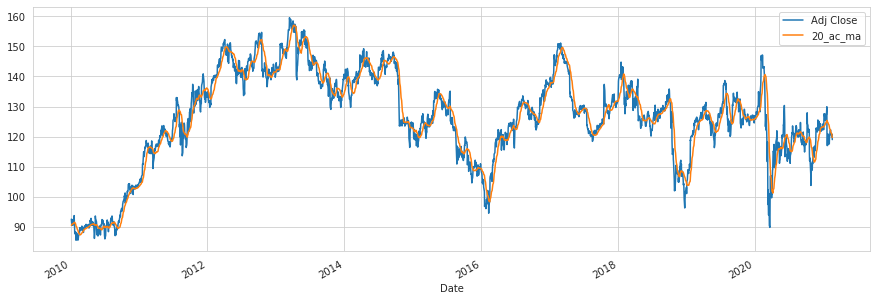

In [74]:
df_ibm[analysis_start_date:end][['Adj Close', '20_ac_ma']].plot(legend=True,figsize=(15,5))

#### Apple stock moving averages

#### Apple stock moving averages

In [121]:
# moving average sizes in days
ma_d_sz = [10,20,50]

# adding moving average columns to dataframe
for mds in ma_d_sz:
    column_name = "%s_ac_ma" %(str(mds))    
    df_aapl[column_name] = moving_average(df_aapl['Adj Close'], window_size=mds)
    df_aapl_train[column_name] = moving_average(df_aapl_train['Adj Close'], window_size=mds)
    df_aapl_test[column_name] = moving_average(df_aapl_test['Adj Close'], window_size=mds)
    df_aapl_valid[column_name] = moving_average(df_aapl_valid['Adj Close'], window_size=mds)

In [122]:
df_aapl.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100922,469033600,NaN,NaN,NaN
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095657,175884800,NaN,NaN,NaN
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088636,105728000,NaN,NaN,NaN
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090830,86441600,NaN,NaN,NaN
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093463,73449600,NaN,NaN,NaN


Moving average feature is empty for the first *n* days, where *n* is the window size, so I'll use some backfill to fill NaN values

In [123]:
df_aapl.fillna(method='backfill', inplace=True)

In [125]:
df_aapl.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100922,469033600,0.101975,0.108974,0.104248
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095657,175884800,0.101975,0.108974,0.104248
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088636,105728000,0.101975,0.108974,0.104248
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090830,86441600,0.101975,0.108974,0.104248
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093463,73449600,0.101975,0.108974,0.104248


In [141]:
df_aapl_train.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100922,469033600,NaN,NaN,NaN
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095657,175884800,NaN,NaN,NaN
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088636,105728000,NaN,NaN,NaN
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090830,86441600,NaN,NaN,NaN
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093463,73449600,NaN,NaN,NaN


In [128]:
df_aapl_test.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2017-02-09,32.912498,33.112499,32.779999,33.105000,31.442188,113399600,NaN,NaN,NaN
2017-02-10,33.115002,33.235001,33.012501,33.029999,31.370947,80262000,NaN,NaN,NaN
2017-02-13,33.270000,33.455002,33.187500,33.322498,31.648762,92141600,NaN,NaN,NaN
2017-02-14,33.367500,33.772499,33.312500,33.755001,32.059544,132904800,NaN,NaN,NaN
2017-02-15,33.880001,34.067501,33.654999,33.877499,32.175884,142492400,NaN,NaN,NaN


In [129]:
df_aapl_valid.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2020-04-30,72.489998,73.632500,72.087502,73.449997,72.885025,183064000,NaN,NaN,NaN
2020-05-01,71.562500,74.750000,71.462502,72.267502,71.711632,240616800,NaN,NaN,NaN
2020-05-04,72.292503,73.422501,71.580002,73.290001,72.726265,133568000,NaN,NaN,NaN
2020-05-05,73.764999,75.250000,73.614998,74.389999,73.817802,147751200,NaN,NaN,NaN
2020-05-06,75.114998,75.809998,74.717499,75.157501,74.579391,142333600,NaN,NaN,NaN


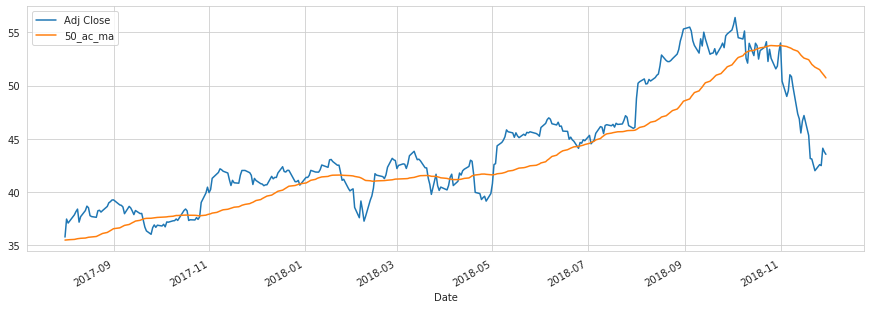

In [83]:
df_aapl[start_date:end_date][['Adj Close', '50_ac_ma']].plot(legend=True,figsize=(15,5))

#### Amazon.com stock moving averages

In [126]:
# moving average sizes in days
ma_d_sz = [10,20,50]

# adding moving average columns to dataframe
for mds in ma_d_sz:
    column_name = "%s_ac_ma" %(str(mds))    
    df_amzn[column_name] = moving_average(df_amzn['Adj Close'], window_size=mds)
    df_amzn_train[column_name] = moving_average(df_amzn_train['Adj Close'], window_size=mds)
    df_amzn_test[column_name] = moving_average(df_amzn_test['Adj Close'], window_size=mds)
    df_amzn_valid[column_name] = moving_average(df_amzn_valid['Adj Close'], window_size=mds)

In [127]:
df_amzn.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,NaN,NaN,NaN
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,NaN,NaN,NaN
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,NaN,NaN,NaN
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,NaN,NaN,NaN
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,NaN,NaN,NaN


Moving average feature is empty for the first *n* days, where *n* is the window size, so I'll use some backfill to fill NaN values

In [86]:
df_amzn.fillna(method='backfill', inplace=True)

In [88]:
df_amzn.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,1.597396,1.57474,1.772813
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,1.597396,1.57474,1.772813
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,1.597396,1.57474,1.772813
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,1.597396,1.57474,1.772813
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,1.597396,1.57474,1.772813


In [140]:
df_amzn_train.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,NaN,NaN,NaN
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,NaN,NaN,NaN
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,NaN,NaN,NaN
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,NaN,NaN,NaN
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,NaN,NaN,NaN


In [130]:
df_amzn_test.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2018-10-03,1981.699951,1989.699951,1949.810059,1952.760010,1952.760010,5253100,NaN,NaN,NaN
2018-10-04,1949.000000,1956.000000,1896.569946,1909.420044,1909.420044,7257000,NaN,NaN,NaN
2018-10-05,1917.989990,1929.079956,1862.829956,1889.650024,1889.650024,6822300,NaN,NaN,NaN
2018-10-08,1874.000000,1902.000000,1830.660034,1864.420044,1864.420044,7393200,NaN,NaN,NaN
2018-10-09,1859.989990,1896.680054,1852.319946,1870.319946,1870.319946,4772900,NaN,NaN,NaN


In [131]:
df_amzn_valid.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2020-08-27,3450.050049,3453.000000,3378.000000,3400.000000,3400.000000,4264800,NaN,NaN,NaN
2020-08-28,3423.000000,3433.370117,3386.500000,3401.800049,3401.800049,2897000,NaN,NaN,NaN
2020-08-31,3408.989990,3495.000000,3405.000000,3450.959961,3450.959961,4185900,NaN,NaN,NaN
2020-09-01,3489.580078,3513.870117,3467.000000,3499.120117,3499.120117,3476400,NaN,NaN,NaN
2020-09-02,3547.000000,3552.250000,3486.689941,3531.449951,3531.449951,3931500,NaN,NaN,NaN


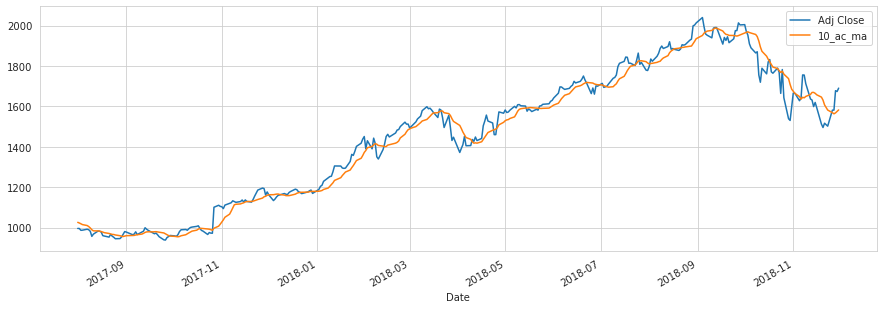

In [89]:
df_amzn[start_date:end_date][['Adj Close', '10_ac_ma']].plot(legend=True,figsize=(15,5))

#### Alphabet Inc. stock moving averages

In [133]:
# moving average sizes in days
ma_d_sz = [10,20,50]

# adding moving average columns to dataframe
for mds in ma_d_sz:
    column_name = "%s_ac_ma" %(str(mds))    
    df_googl[column_name] = moving_average(df_googl['Adj Close'], window_size=mds)
    df_googl_train[column_name] = moving_average(df_googl_train['Adj Close'], window_size=mds)
    df_googl_test[column_name] = moving_average(df_googl_test['Adj Close'], window_size=mds)
    df_googl_valid[column_name] = moving_average(df_googl_valid['Adj Close'], window_size=mds)

In [134]:
df_googl.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096,NaN,NaN,NaN
2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343,NaN,NaN,NaN
2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126,NaN,NaN,NaN
2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337,NaN,NaN,NaN
2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602,NaN,NaN,NaN


Moving average feature is empty for the first *n* days, where *n* is the window size, so I'll use some backfill to fill NaN values

In [135]:
df_googl.fillna(method='backfill', inplace=True)

In [136]:
df_googl.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096,52.432933,52.692943,63.586987
2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343,52.432933,52.692943,63.586987
2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126,52.432933,52.692943,63.586987
2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337,52.432933,52.692943,63.586987
2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602,52.432933,52.692943,63.586987


In [137]:
df_googl_train.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096,NaN,NaN,NaN
2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343,NaN,NaN,NaN
2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126,NaN,NaN,NaN
2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337,NaN,NaN,NaN
2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602,NaN,NaN,NaN


In [138]:
df_googl_test.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2019-06-27,1086.750000,1088.459961,1075.849976,1076.630005,1076.630005,1203900,NaN,NaN,NaN
2019-06-28,1077.229980,1082.800049,1073.800049,1082.800049,1082.800049,1683600,NaN,NaN,NaN
2019-07-01,1101.040039,1108.589966,1095.329956,1100.000000,1100.000000,1459800,NaN,NaN,NaN
2019-07-02,1104.829956,1112.890015,1099.670044,1112.599976,1112.599976,1031500,NaN,NaN,NaN
2019-07-03,1118.500000,1127.989990,1114.849976,1122.989990,1122.989990,1007700,NaN,NaN,NaN


In [139]:
df_googl_valid.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2020-10-20,1523.109985,1573.839966,1520.500000,1551.079956,1551.079956,2083500,NaN,NaN,NaN
2020-10-21,1569.849976,1615.140015,1567.140015,1585.989990,1585.989990,3016100,NaN,NaN,NaN
2020-10-22,1585.000000,1613.420044,1577.479980,1606.660034,1606.660034,1525600,NaN,NaN,NaN
2020-10-23,1615.050049,1634.119995,1611.910034,1632.979980,1632.979980,1527400,NaN,NaN,NaN
2020-10-26,1615.000000,1629.579956,1567.780029,1584.290039,1584.290039,1791300,NaN,NaN,NaN


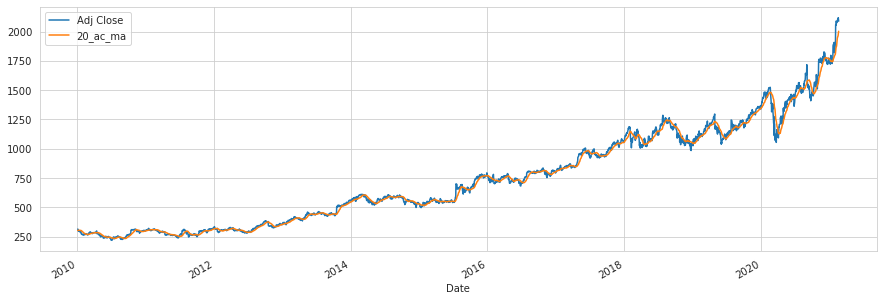

In [95]:
df_googl[analysis_start_date:end][['Adj Close', '20_ac_ma']].plot(legend=True,figsize=(15,5))

### Metrics computation

Computing metrics on the benchmark model will give me a good reference to evaluate the deep learning model after training.

As can be presumed and seen from data prints, first `n` values of validation data are `NaN` so, it will be better just to exclude the first `n-1` values from the validation set to avoid misleading values to be catch in metrics evaluation. 

In [149]:
from sklearn.metrics import mean_squared_error

#### IBM stock

In [163]:
n = 10
ma_str = str(n)+'_ac_ma'

In [169]:
ibm_ma_mse_loss = mean_squared_error(df_ibm_valid.iloc[n-1:]['Adj Close'], df_ibm_valid.iloc[n-1:][ma_str])

In [170]:
print(ibm_ma_mse_loss)

20.88764115837781


In [173]:
n = 20
ma_str = str(n)+'_ac_ma'

In [174]:
ibm_ma_mse_loss = mean_squared_error(df_ibm_valid.iloc[n-1:]['Adj Close'], df_ibm_valid[n-1:][ma_str])

In [175]:
print(ibm_ma_mse_loss)

50.54417499866799


In [178]:
n = 50
ma_str = str(n)+'_ac_ma'

In [179]:
ibm_ma_mse_loss = mean_squared_error(df_ibm_valid.iloc[n-1:]['Adj Close'], df_ibm_valid[n-1:][ma_str])

In [180]:
print(ibm_ma_mse_loss)

84.16199909718462


#### Apple Inc. stock

In [103]:
aapl_10ma_mse_loss = mean_squared_error(df_aapl['Adj Close'], df_aapl['10_ac_ma'])

In [104]:
print(aapl_10ma_mse_loss)

0.5904003486257521


In [105]:
aapl_20ma_mse_loss = mean_squared_error(df_aapl['Adj Close'], df_aapl['20_ac_ma'])

In [106]:
print(aapl_20ma_mse_loss)

1.2972070531787763


In [107]:
aapl_50ma_mse_loss = mean_squared_error(df_aapl['Adj Close'], df_aapl['50_ac_ma'])

In [108]:
print(aapl_50ma_mse_loss)

3.92653150934996


#### Amazon.com stock

In [109]:
amzn_10ma_mse_loss = mean_squared_error(df_amzn['Adj Close'], df_amzn['10_ac_ma'])

In [110]:
print(amzn_10ma_mse_loss)

695.4867445525978


In [111]:
amzn_20ma_mse_loss = mean_squared_error(df_amzn['Adj Close'], df_amzn['20_ac_ma'])

In [112]:
print(amzn_20ma_mse_loss)

1420.5802644474145


In [113]:
amzn_50ma_mse_loss = mean_squared_error(df_amzn['Adj Close'], df_amzn['50_ac_ma'])

In [114]:
print(amzn_50ma_mse_loss)

3641.462961696154


#### Alphabet Inc. stock

In [115]:
googl_10ma_mse_loss = mean_squared_error(df_googl['Adj Close'], df_googl['10_ac_ma'])

In [116]:
print(googl_10ma_mse_loss)

386.4951901295182


In [117]:
googl_20ma_mse_loss = mean_squared_error(df_googl['Adj Close'], df_googl['20_ac_ma'])

In [118]:
print(googl_20ma_mse_loss)

848.8287162842605


In [119]:
googl_50ma_mse_loss = mean_squared_error(df_googl['Adj Close'], df_googl['50_ac_ma'])

In [120]:
print(googl_50ma_mse_loss)

2111.4464762363505


As expected, loss augments as we observe moving average on larger windows